## Application of ESBM for clustering on simulated data

In [ ]:
from pyesbm.model import BaseESBM
from pyesbm.priors import GnedinProcess, DirichletProcess, PitmanYorProcess
from pyesbm.likelihoods import PoissonGamma
from pyesbm.utilities.plotting_functions import plot_heatmap
from pyesbm.utilities.vi_functs import VI
from pyesbm.utilities.data_generation import generate_poisson_data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

This notebook shows how to use ESBM for clustering simulated data.
ESBM is a Bayesian Non-Parametric Stochastic Block-Model that uses Gibbs-type prior on the clustering structure. The general model can be written as:
$$
\begin{split}
\mathbf{z} &\sim \text{Gibbs-type prior}\\
\theta &\sim \pi(\theta|\eta)\\
y_{ui} \mid \mathbf{z}, \Theta &\sim p(y|\mathbf{z}, \Theta, \xi)
\end{split}
$$
where:
- $p(y|\mathbf{z}, \Theta, \xi)$ is the distribution of the entries of the adjacency matrix depending on the clustering structure $\mathbf{z}$ and possibly some other parameters $\theta, \xi$
- $pi(\cdot, \eta)$ is the prior imposed on $\theta$ possibly depending on some parameters $\eta$
- $\mathbf{z}$ is the partition structure on which we impose a prior of Gibbs-type. The rest of the notebook uses a Gnedin Process (an instance of Gibbs-type) but the code already has implementation for Dirichlet Process, Pittman-Yor Process, the Dirichlet-Multinomial model and it allows the user to specify their own prior sampling scheme.

The rest of the notebook presents an application of clustering on a simulated bipartite, count-valued network.

## Data Generation

Manually define the cluster partition and generate data from a Poisson distribution with Gamma prior on the mean. This creates a modular structure which will be learned by the model.

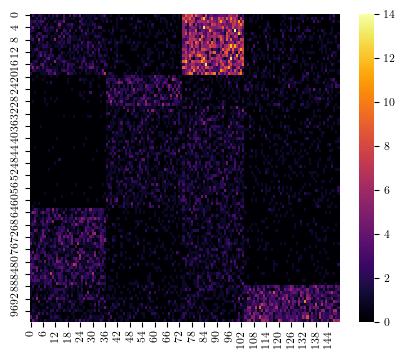

In [2]:
n = 100
n2 = 150

rng = np.random.default_rng(1)

# manually define cluster sizes and assignments
sizes_1 = [
    n // 5,
    n // 10,
    n // 3,
    n // 4,
    n - (n // 3) - (n // 4) - (n // 5) - (n // 10),
]

clustering_1 = np.array(
    [0 for _ in range(sizes_1[0])]
    + [1 for _ in range(sizes_1[1])]
    + [2 for _ in range(sizes_1[2])]
    + [3 for _ in range(sizes_1[3])]
    + [4 for _ in range(sizes_1[4])]
)

# manually define cluster sizes and assignments
sizes_2 = [n2 // 4, n2 // 4, n2 // 5, n2 - (n2 // 4) - (n2 // 4) - (n2 // 5)]

clustering_2 = np.array(
    [0 for _ in range(sizes_2[0])]
    + [1 for _ in range(sizes_2[1])]
    + [2 for _ in range(sizes_2[2])]
    + [3 for _ in range(sizes_2[3])]
)

# generate bipartite Poisson data
Y = generate_poisson_data(
    1, 1, clustering_1, clustering_2=clustering_2, bipartite=True, rng=rng
)

# quick visualization
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(Y, cmap="inferno", ax=ax)
plt.show()

The adjacency matrix clearly displays a block structure. We now shuffle the entries such that the partition is not immediately apparent

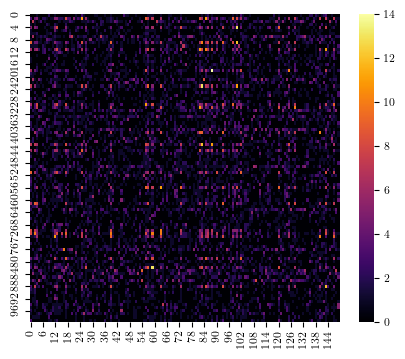

In [3]:
# shuffle the adjacency matrix and cluster assignments
a = rng.permutation(n)
b = rng.permutation(n2)
clustering_1 = clustering_1[a]
clustering_2 = clustering_2[b]
Y = Y[a][:, b]

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(Y, cmap="inferno", ax=ax)
plt.show()

## Model Set-up

Having count-valued data the easy choice for likelihood-prior is the a Poisson-Gamma model and we can simply sue two cluster assignment vector (one for each "side" of the network):
$$
\begin{split}
\mathbf{z}, \mathbf{q} &\sim \text{Gibbs-type prior}\\
\theta_{h, k}|a, b &\sim \text{Gamma}(a, b)\\
y_ui \mid z, q, \Theta &\sim \text{Poisson}(\theta_{h, k})
\end{split}
$$

For this toy example we will use a $Gamma(1, 1)$ prior. For the clustering structure prior we can guide our choice of hyper-parameters using the expected, a prior, number of clusters. This depends both on the hyper-parameter we choose and on the number of nodes

To get a conservative initialization we set the hyperparameters such that all 3 schemes have $\approx 7$ expected clusters which is slightly higher than the true number of clusters.

In [4]:
prior_shape = 1
prior_rate = 1
gamma = 0.5
epsilon = 1e-10
burn_in = 200
thinning = 2


likelihood = PoissonGamma(shape=prior_shape, rate=prior_rate)
gnedin_prior = GnedinProcess(gamma=0.55)
dp_prior = DirichletProcess(concentration=1.55)
pyp_prior = PitmanYorProcess(scheme_param=1.1, sigma=0.1)

print("Expected number of clusters (Gnedin): ", gnedin_prior.expected_num_clusters(n))
print("Expected number of clusters (DP): ", dp_prior.expected_num_clusters(n))
print("Expected number of clusters (PYP): ", pyp_prior.expected_num_clusters(n))

Expected number of clusters (Gnedin):  7.069273579201184
Expected number of clusters (DP):  7.026765282986997
Expected number of clusters (PYP):  7.0755870112060855


The cell below shows the log-likelihood for the true partition and its adjacency matrix.

-7691.127948300976


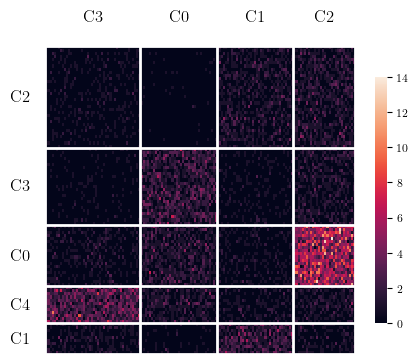

In [5]:
gen_model = BaseESBM(
    Y,
    prior=gnedin_prior,
    clustering=[clustering_1, clustering_2],
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=True,
    verbose=False,
    rng=rng,
)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(5, 4), bipartite=True, triangular_mask=False)

#### Collapsed Gibbs sampler

The model is estimated running a collapsed Gibbs sampler where we sample only the cluster assignment for each nodes. For this example we use only 200 iterations since in this case this is enough to get convergence (in practice we would probably need to take a much higher number of samples).

The model is initialised with one cluster per node as this has proven (in my experience) to be the most stable initialisation. Indeed with a draw from the prior the model tends to converge very quickly to a stable configuration which becomes very difficult to escape from.

In [6]:
rng = np.random.default_rng(2)

gnedin_model = BaseESBM(
    Y,
    prior=gnedin_prior,
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=True,
    verbose=False,
    clustering=None,
    rng=rng,
)

dp_model = BaseESBM(
    Y,
    prior=dp_prior,
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=True,
    verbose=False,
    clustering=None,
    rng=rng,
)

py_model = BaseESBM(
    Y,
    prior=pyp_prior,
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=True,
    verbose=False,
    clustering=None,
    rng=rng,
)

# takes around 30s to run
gnedin_out = gnedin_model.fit(n_iters=1000, verbose=False)
dp_out = dp_model.fit(n_iters=1000, verbose=False)
py_out = py_model.fit(n_iters=1000, verbose=False)

To see how the training has progressed we can look at the traceplot of the log-likelihood. We see from the output below that the model very quickly converges to a stable configuration.

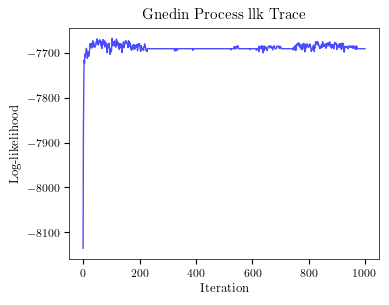

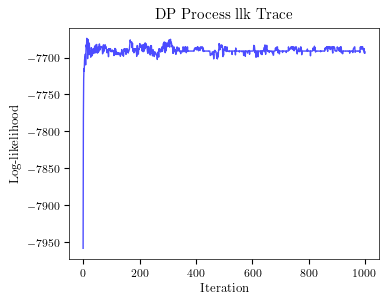

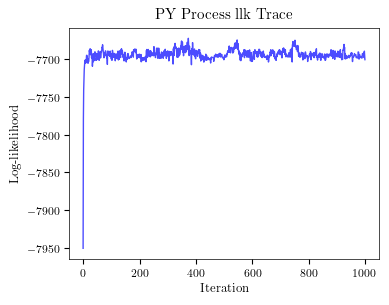

In [7]:
gnedin_model.plot_trace("Gnedin Process llk Trace", start=1, figsize=(4, 3))
dp_model.plot_trace("DP Process llk Trace", start=1, figsize=(4, 3))
py_model.plot_trace("PY Process llk Trace", start=1, figsize=(4, 3))

We can then use WAIC to compare different models and see which prior works best for out case and from the output below we see that the Dirichlet Process prior is the best choice as it has the lowest among the three.

In [8]:
gnedin_waic = gnedin_model.compute_waic(burn_in=2, thinning=1)
dp_waic = dp_model.compute_waic(burn_in=2, thinning=1)
py_waic = py_model.compute_waic(burn_in=2, thinning=1)

print("Gnedin WAIC: ", gnedin_waic)
print("DP WAIC: ", dp_waic)
print("PYP WAIC: ", py_waic)

Gnedin WAIC:  29156.636049476336
DP WAIC:  29154.659357889126
PYP WAIC:  29159.851867203102


Assuming the we don't know the true partition, our goal is to do inference on the estimated clustering. We use here two tools:
- quantiles of the posterior distribution for the number of non-empty groups. 
- credible balls around the estimated partition. The partition is estimated by  

**Quantiles** give us an idea of how many clusters are in our network and we see from the output below that we are quite confident that there are betwen 4 and 5 communities in the first side of the network and betwen 3 and 4 in the second.

The **estimated partition** $\hat{z}$ is obtained by minimising the Variation of Information (VI) through a greedy algorithm (see Wade & 2008). Credible balls are obtaned by again using the VI metric and described as the (sampled) partitions in the credible ball with:
- the fewest clusters that are most distant to $\hat{z}$ (upper vertical) 
- the most clusters that are most distant to $\hat{z}$ (lower vertical)
- the greatest distance to $\hat{z}$ (horizontal)

For clarity in the output below we report the distance between $\hat{z}$ and these partition rather than the partition themselves (not easy to visualise)

To obtain these quantities use burn-in and thinnign to get uncorrelated monte-carlo samples.

In [9]:
draws_gnedin_1 = gnedin_model.mcmc_draws_1[burn_in::thinning]
draws_dp_1 = dp_model.mcmc_draws_1[burn_in::thinning]
draws_py_1 = py_model.mcmc_draws_1[burn_in::thinning]

draws_gnedin_2 = gnedin_model.mcmc_draws_2[burn_in::thinning]
draws_dp_2 = dp_model.mcmc_draws_2[burn_in::thinning]
draws_py_2 = py_model.mcmc_draws_2[burn_in::thinning]

max_clusters_gnedin_1 = np.max(draws_gnedin_1, axis=1)
max_clusters_dp_1 = np.max(draws_dp_1, axis=1)
max_clusters_py_1 = np.max(draws_py_1, axis=1)

max_clusters_gnedin_2 = np.max(draws_gnedin_2, axis=1)
max_clusters_dp_2 = np.max(draws_dp_2, axis=1)
max_clusters_py_2 = np.max(draws_py_2, axis=1)

res_gnedin_1 = np.quantile(max_clusters_gnedin_1, [0.025, 0.5, 0.975])
res_dp_1 = np.quantile(max_clusters_dp_1, [0.025, 0.5, 0.975])
res_py_1 = np.quantile(max_clusters_py_1, [0.025, 0.5, 0.975])
print(
    "Gnedin estimated number of clusters for node set 1 (2.5%, 50%, 97.5%): ",
    res_gnedin_1,
)
print("DP estimated number of clusters for node set 1 (2.5%, 50%, 97.5%): ", res_dp_1)
print("PYP estimated number of clusters for node set 1 (2.5%, 50%, 97.5%): ", res_py_1)

res_gnedin_2 = np.quantile(max_clusters_gnedin_2, [0.025, 0.5, 0.975])
res_dp_2 = np.quantile(max_clusters_dp_2, [0.025, 0.5, 0.975])
res_py_2 = np.quantile(max_clusters_py_2, [0.025, 0.5, 0.975])
print(
    "\nGnedin estimated number of clusters for node set 2 (2.5%, 50%, 97.5%): ",
    res_gnedin_2,
)
print("DP estimated number of clusters for node set 2 (2.5%, 50%, 97.5%): ", res_dp_2)
print("PYP estimated number of clusters for node set 2 (2.5%, 50%, 97.5%): ", res_py_2)

Gnedin estimated number of clusters for node set 1 (2.5%, 50%, 97.5%):  [4. 4. 5.]
DP estimated number of clusters for node set 1 (2.5%, 50%, 97.5%):  [4. 5. 6.]
PYP estimated number of clusters for node set 1 (2.5%, 50%, 97.5%):  [4. 4. 6.]

Gnedin estimated number of clusters for node set 2 (2.5%, 50%, 97.5%):  [3. 3. 4.]
DP estimated number of clusters for node set 2 (2.5%, 50%, 97.5%):  [3. 3. 4.]
PYP estimated number of clusters for node set 2 (2.5%, 50%, 97.5%):  [4. 4. 6.]


In [10]:
estimated_gnedin = gnedin_model.estimate_cluster_assignment_vi(
    burn_in=burn_in, thinning=thinning
)
estimated_dp = dp_model.estimate_cluster_assignment_vi(
    burn_in=burn_in, thinning=thinning
)
estimated_py = py_model.estimate_cluster_assignment_vi(
    burn_in=burn_in, thinning=thinning
)

In [11]:
cb1_gn, cb2_gn = gnedin_model.credible_ball(
    burn_in=burn_in, thinning=thinning, alpha=0.05
)
cb1_dp, cb2_dp = dp_model.credible_ball(burn_in=burn_in, thinning=thinning, alpha=0.05)
cb1_py, cb2_py = py_model.credible_ball(burn_in=burn_in, thinning=thinning, alpha=0.05)

print("\nCredible ball information [upper vertical, lower vertical, horizontal]")

print(
    f"\nGnedin node set 1: {np.round(cb1_gn['dist_uppervert'], 2)}, {np.round(cb1_gn['dist_lowervert'], 2)}, {np.round(cb1_gn['dist_horiz'], 2)}"
)
print(
    f"Gnedin node set 2: {np.round(cb2_gn['dist_uppervert'], 2)}, {np.round(cb2_gn['dist_lowervert'], 2)}, {np.round(cb2_gn['dist_horiz'], 2)}"
)

print(
    f"\nDP node set 1: {np.round(cb1_dp['dist_uppervert'], 2)}, {np.round(cb1_dp['dist_lowervert'], 2)}, {np.round(cb1_dp['dist_horiz'], 2)}"
)
print(
    f"DP node set 2: {np.round(cb2_dp['dist_uppervert'], 2)}, {np.round(cb2_dp['dist_lowervert'], 2)}, {np.round(cb2_dp['dist_horiz'], 2)}"
)

print(
    f"\nPY node set 1: {np.round(cb1_py['dist_uppervert'], 2)}, {np.round(cb1_py['dist_lowervert'], 2)}, {np.round(cb1_py['dist_horiz'], 2)}"
)
print(
    f"PY node set 2: {np.round(cb2_py['dist_uppervert'], 2)}, {np.round(cb2_py['dist_lowervert'], 2)}, {np.round(cb2_py['dist_horiz'], 2)}"
)


Credible ball information [upper vertical, lower vertical, horizontal]

Gnedin node set 1: 1.47, 2.36, 2.36
Gnedin node set 2: 1.26, 2.32, 2.33

DP node set 1: 1.53, 2.67, 2.67
DP node set 2: 1.33, 2.0, 2.0

PY node set 1: 1.53, 2.09, 2.09
PY node set 2: 1.5, 2.3, 2.31


### Comparison with true partition

In this case we have access to the true partition so we can see how it compared to the estimated partition. To do this we can both compute the VI distance between true and estimated or simply do a graphical analysis (i.e. compare the adjacency matrices)

In [12]:
vi_gn_1 = VI(estimated_gnedin[0], clustering_1)
vi_gn_2 = VI(estimated_gnedin[2], clustering_2)

vi_dp_1 = VI(estimated_dp[0], clustering_1)
vi_dp_2 = VI(estimated_dp[2], clustering_2)

vi_py_1 = VI(estimated_py[0], clustering_1)
vi_py_2 = VI(estimated_py[2], clustering_2)

print("VI distance between true and estimated partitions:")
print(f"\nGnedin node set 1: {vi_gn_1}, node set 2: {vi_gn_2}")
print(f"DP node set 1: {vi_dp_1}, node set 2: {vi_dp_2}")
print(f"PY node set 1: {vi_py_1}, node set 2: {vi_py_2}")

VI distance between true and estimated partitions:

Gnedin node set 1: [0.], node set 2: [0.]
DP node set 1: [0.], node set 2: [0.]
PY node set 1: [0.], node set 2: [0.]


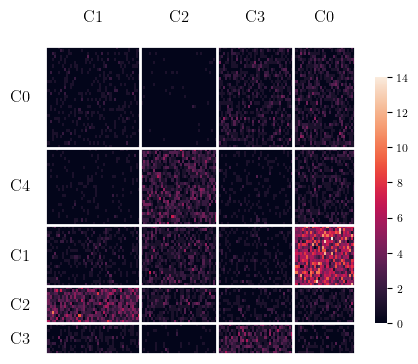

In [13]:
plot_heatmap(gnedin_model, size=(5, 4), bipartite=True, triangular_mask=False)